## Periodicals networks

In [2]:
library(tidyverse)
library(tidytext)
library(topicmodels)

library(igraph)
library(sna)
library(ggraph)

library(wesanderson)
library(patchwork)
theme_set(theme_minimal())

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Dołączanie pakietu: ‘igraph’


Następujące obiekty zostały zakryte z ‘package:dplyr’:

    as_data_frame, groups, union


Następujące obiekty zostały zakryte z ‘package:purrr’:

    compose, simplify


Następujący obiekt został zakryty z ‘package:tidyr’:

    crossing


Następujący obiekt został zakryty z ‘package:tibble’:

    as_data_frame


Następujące obiekty zostały zakryte z ‘package:stats’:

    decompose, spectrum


Następujący obiekt został zakryty z ‘package:base’:

    union


Ładowanie wymaganego pakietu: statnet.common


Dołączanie pakietu: ‘statnet.common’


Następujące obiekty zostały zakryte z

In [3]:
# load model output
load("../data/lda75_output.Rda")

# load code for edges calculation
source("03_fn_calculate_edges.R")

# function to extract topic lables:
get_topic_labels = function(x, n_labels = 10) {
  
  #takes beta-matrix as an input
  top_terms = x %>%
    group_by(topic) %>%
    top_n(20, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)
  
  topic_labels = top_terms %>%
    group_by(topic) %>%
    top_n(n_labels, beta) %>%
    summarise(label=paste(term, collapse=" ")) %>%
    mutate(label = paste(topic, label, sep="_"))
  
  return(topic_labels)
}

In [4]:
gamma <- gamma %>% 
    # add index for create_edges function
    mutate(index = paste0(corpus, "_", id)) %>% 
    # fix typo
    rename(author = first_line)

glimpse(gamma)

Rows: 1,076,700
Columns: 8
$ corpus  <chr> "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N…
$ id      <chr> "1-1", "1-2", "1-3", "10-1", "10-2", "100-1", "100-2", "100-3"…
$ year    <chr> "1785", "1785", "1785", "1803", "1803", "1810", "1810", "1810"…
$ author  <chr> "ССБобров", "ССБобров", "ССБобров", "ССБобров", "ССБобров", "А…
$ formula <chr> "iamb_4", "iamb_4", "iamb_4", "iamb_4", "iamb_4", "iamb_6", "i…
$ topic   <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ gamma   <dbl> 0.019108280, 0.006211180, 0.006451613, 0.006211180, 0.00763358…
$ index   <chr> "N_1-1", "N_1-2", "N_1-3", "N_10-1", "N_10-2", "N_100-1", "N_1…


## Random text selection 

Problem: overrepresented authors in RNC & date inconsistency between RNC vs periodicals corpora

author,n_gamma,n_texts
<chr>,<int>,<dbl>
МЮЛермонтов,30150,402
АСПушкин,20100,268
ВГБенедиктов,12750,170
ВАЖуковский,11100,148
АИПолежаев,10200,136
НМЯзыков,7650,102
АВКольцов,6975,93
НАНекрасов,4725,63
ППЕршов,4350,58


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    3.00   15.00   31.63   29.75  402.00 

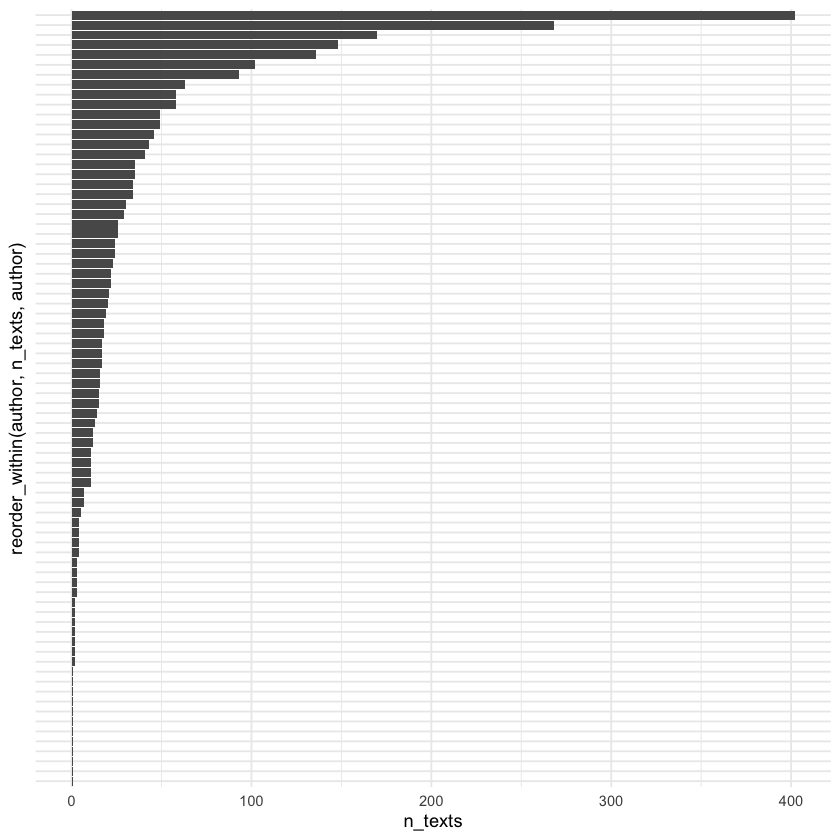

In [5]:
rnc_authors <- gamma %>% 
    filter(corpus == "N") %>% 
    mutate(decade = floor(as.numeric(year)/5)*5) %>% 
    filter(decade %in% c(1830, 1835)) %>% 
    group_by(author) %>% 
    summarise(n_gamma = sum(n()),
             n_texts = n_gamma/75) %>% 
    arrange(desc(n_texts))

head(rnc_authors, 20)
summary(rnc_authors$n_texts)

rnc_authors %>% 
    ggplot(aes(x = n_texts, 
               y = reorder_within(author, n_texts, author))) + 
    geom_col() +
    theme(axis.text.y = element_blank())

Sampling

In [6]:
# filter overpresented authors
top_authors <- rnc_authors %>% 
    filter(n_texts > 30) %>% select(author) # 19 authors

# randomly select 30 texts by each author
sampled_id <- gamma %>% 
    filter(corpus == "N") %>% 
    # select slice
    filter(year > 1829 & year < 1840) %>%
    select(index, author) %>% 
    distinct() %>% 
    filter(author %in% top_authors$author) %>% 
    group_by(author) %>% 
    sample_n(30) %>% 
    ungroup() %>%
    select(-author)

# retrieve gamma values for samples for these authors
gamma_top <- inner_join(sampled_id, gamma, by = "index", multiple = "all")

Merging

In [7]:
# select texts from RNC by non-prevalent authors
gamma_nontop <- gamma %>% 
    filter(corpus == "N" & !author %in% top_authors$author) %>% 
    filter(year > 1829 & year < 1840)

# retrieve all the gamma values for texts from periodicals
gamma_periodicals <- gamma %>% 
    filter(corpus == "P") %>% 
    filter(year > 1829 & year < 1840) 

# merge the three together
gamma1830 <- rbind(gamma_top, gamma_nontop, gamma_periodicals)

head(gamma1830)

print("Number of texts in each corpus after sampling:")
gamma1830 %>% 
    select(index, corpus) %>% 
    distinct() %>% 
    group_by(corpus) %>% 
    count()

index,corpus,id,year,author,formula,topic,gamma
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,1,0.008695652
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,2,0.008695652
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,3,0.008695652
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,4,0.008695652
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,5,0.008695652
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,6,0.008695652


[1] "Number of texts in each corpus after sampling:"


corpus,n
<chr>,<int>
N,1173
P,1191


In [8]:
save(gamma1830, file = "../data/gamma_1830.Rda")

## Preparation of nodes & edges

Extract topic labels

In [9]:
topic_labels <- get_topic_labels(beta, n_labels = 5)
head(topic_labels)

topic,label
<int>,<chr>
1,1_старик девица красный молодой старый
2,2_брат два жена муж другой
3,3_искать исчезать везде дух след
4,4_дева прекрасный краса чистый молодой
5,5_бог давать сила боже господь
6,6_слава великий герой отечество россия


Create edges: detect highly probable topics appeared in the same poems

In [14]:
edges_1830 <- compute_edges(gamma1830,
                           gamma_thresh = 0.05,
                           time_slice = 5)

head(edges_1830)

index,corpus,id,year,author,formula,topic,gamma,from,to,slice,edge_id,source,target
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,23,0.06086957,23,25,1830,23 25,23_белый грудь черный лицо кудри,25_взор око речь взгляд улыбка
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,23,0.06086957,23,34,1830,23 34,23_белый грудь черный лицо кудри,34_слеза сердце плакать тоска печаль
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,23,0.06086957,23,37,1830,23 37,23_белый грудь черный лицо кудри,37_огонь пламень грудь гореть око
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,23,0.06086957,23,56,1830,23 56,23_белый грудь черный лицо кудри,56_рука нога голова глаз подымать
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,25,0.04347826,25,34,1830,25 34,25_взор око речь взгляд улыбка,34_слеза сердце плакать тоска печаль
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,25,0.04347826,25,37,1830,25 37,25_взор око речь взгляд улыбка,37_огонь пламень грудь гореть око


In [32]:
# select top meters
meter_counts_1830 <- gamma1830 %>% 
  rename("meter" = "formula") %>% 
  filter(!str_detect(meter, "other") & meter != "NA") %>% 
  group_by(meter, corpus) %>% 
  count(sort = T) %>% 
  mutate(n_texts = n/75) %>%
  ungroup() %>% 
  filter(n > 10)

head(meter_counts_1830, 20)

meter,corpus,n,n_texts
<chr>,<chr>,<int>,<dbl>
iamb_4,N,24675,329
iamb_4,P,24375,325
iamb_free,P,21975,293
trochee_4,P,11700,156
trochee_4,N,10950,146
iamb_free,N,10500,140
iamb_5,N,9300,124
iamb_6,N,6150,82
iamb_6,P,4875,65


In [22]:
top_meters_1830 <- meter_counts_1830 %>% 
  group_by(meter) %>%
  summarise(total = sum(n)) %>% 
  arrange(desc(total))

head(top_meters_1830, 15)
top_meters_1830$meter[1:8]

meter,total
<chr>,<int>
iamb_4,49050
iamb_free,32475
trochee_4,22650
iamb_5,13275
iamb_6,11025
amphibrach_4,6750
trochee_free,3675
amphibrach_free,2550
anapaest_free,2400


[1] "iamb_4"          "iamb_free"       "trochee_4"       "iamb_5"         
[5] "iamb_6"          "amphibrach_4"    "trochee_free"    "amphibrach_free"

In [25]:
links_1830 <- edges_1830 %>% 
  mutate(meter = formula) %>%
  # filter out only 8 most interesting meters
  filter(meter %in% top_meters_1830$meter[1:8]) %>% 
  # group and count edges
  group_by(meter, corpus) %>% 
  count(meter, edge_id, source, target, sort = T) %>% 
  # filter non-frequent edges
  filter(n > 2) %>% 
  ungroup() 

# quick check
head(links_1830)

meter,corpus,edge_id,source,target,n
<chr>,<chr>,<chr>,<chr>,<chr>,<int>
iamb_free,P,30 42,30_небо земля мир земной небесный,42_душа мечта поэт живой восторг,10
iamb_4,P,8 74,8_звезда небо луна ночь луч,74_луч солнце небо заря блистать,9
iamb_4,N,30 42,30_небо земля мир земной небесный,42_душа мечта поэт живой восторг,8
iamb_4,P,24 72,24_вода луг тень ручей роща,72_гора лес скала дикий стоять,8
iamb_4,P,30 74,30_небо земля мир земной небесный,74_луч солнце небо заря блистать,8
trochee_4,P,8 26,8_звезда небо луна ночь луч,26_волна море берег вода брег,8


Create node- and edgelist

In [26]:
edgelist <- links_1830 %>% 
  select(source, target, n, meter, corpus) %>% 
  mutate(width = n/10)

nodelist <- tibble(source = unique(c(links_1830$target, 
                                     links_1830$source))) %>% 
  mutate(idn = as.numeric(str_replace(source, "^([0-9].*?)_.*", "\\1"))) 

head(edgelist)
head(nodelist) 
nrow(nodelist)

source,target,n,meter,corpus,width
<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
30_небо земля мир земной небесный,42_душа мечта поэт живой восторг,10,iamb_free,P,1.0
8_звезда небо луна ночь луч,74_луч солнце небо заря блистать,9,iamb_4,P,0.9
30_небо земля мир земной небесный,42_душа мечта поэт живой восторг,8,iamb_4,N,0.8
24_вода луг тень ручей роща,72_гора лес скала дикий стоять,8,iamb_4,P,0.8
30_небо земля мир земной небесный,74_луч солнце небо заря блистать,8,iamb_4,P,0.8
8_звезда небо луна ночь луч,26_волна море берег вода брег,8,trochee_4,P,0.8


source,idn
<chr>,<dbl>
42_душа мечта поэт живой восторг,42
74_луч солнце небо заря блистать,74
72_гора лес скала дикий стоять,72
26_волна море берег вода брег,26
55_душа жизнь страсть страдание мука,55
75_сердце душа любовь дар радость,75


[1] 73

## Networks visualisations

### Create network

In [27]:
net30 <- graph_from_data_frame(d = edgelist, vertices = nodelist, directed = F)
net30

IGRAPH 2c5312c UN-- 73 638 -- 
+ attr: name (v/c), idn (v/n), n (e/n), meter (e/c), corpus (e/c),
| width (e/n)
+ edges from 2c5312c (vertex names):
[1] 42_душа мечта поэт живой восторг--30_небо земля мир земной небесный     
[2] 74_луч солнце небо заря блистать--8_звезда небо луна ночь луч           
[3] 42_душа мечта поэт живой восторг--30_небо земля мир земной небесный     
[4] 72_гора лес скала дикий стоять  --24_вода луг тень ручей роща           
[5] 74_луч солнце небо заря блистать--30_небо земля мир земной небесный     
[6] 26_волна море берег вода брег   --8_звезда небо луна ночь луч           
[7] 42_душа мечта поэт живой восторг--12_любовь сердце страсть кровь чувство
+ ... omitted several edges

#### Betweenness

In [28]:
# extract betweenness stats
betw = igraph::betweenness(net30)
head(betw)

# named vector to tibble
# str(betw)

betw_tib <- as_tibble(as.list(betw)) %>% 
  mutate(x = "x") %>% 
  pivot_longer(!x, names_to = "source", values_to = "betw") %>% 
  select(-x)
head(betw_tib)

# attach betweenness values to nodelist
nodelist <- inner_join(nodelist, betw_tib, by = "source")

42_душа мечта поэт живой восторг     74_луч солнце небо заря блистать 
                           268.03611                            125.28018 
      72_гора лес скала дикий стоять        26_волна море берег вода брег 
                            90.44664                             94.66034 
55_душа жизнь страсть страдание мука    75_сердце душа любовь дар радость 
                           353.49782                             40.14453

source,betw
<chr>,<dbl>
42_душа мечта поэт живой восторг,268.03611
74_луч солнце небо заря блистать,125.28018
72_гора лес скала дикий стоять,90.44664
26_волна море берег вода брег,94.66034
55_душа жизнь страсть страдание мука,353.49782
75_сердце душа любовь дар радость,40.14453


#### degree

In [30]:
# extract degree values
deg <- igraph::degree(net30, mode="all")
head(deg)

degree_tib <- as_tibble(as.list(deg)) %>% 
  mutate(x = "x") %>% 
  pivot_longer(!x, names_to = "source", values_to = "degree") %>% 
  select(-x)

# attach degree to nodelist
nodelist <- inner_join(nodelist, degree_tib, by = "source")

head(nodelist)

42_душа мечта поэт живой восторг     74_луч солнце небо заря блистать 
                                  73                                   49 
      72_гора лес скала дикий стоять        26_волна море берег вода брег 
                                  31                                   39 
55_душа жизнь страсть страдание мука    75_сердце душа любовь дар радость 
                                  58                                   14

source,idn,betw,degree
<chr>,<dbl>,<dbl>,<dbl>
42_душа мечта поэт живой восторг,42,268.03611,73
74_луч солнце небо заря блистать,74,125.28018,49
72_гора лес скала дикий стоять,72,90.44664,31
26_волна море берег вода брег,26,94.66034,39
55_душа жизнь страсть страдание мука,55,353.49782,58
75_сердце душа любовь дар радость,75,40.14453,14


#### upd net30

In [31]:
net1830 <- graph_from_data_frame(d=edgelist, vertices=nodelist, directed=F)

### networks viz

In [47]:
# function for network visualisation

# taken as input net, meter as a string & colour palette value
# corpus is "N" for RNC, "P" for periodicals

network <- function(network, meter_value, palette_v) {
  ggraph(network, layout = "stress") +
    geom_edge_fan(aes(color = meter,
                      filter = meter %in% c(meter_value), 
                      width = n, 
                      alpha = 0.4)) +
    geom_node_point(aes(alpha = degree)) +
    geom_node_text(aes(label=idn), 
                   hjust=0.1, 
                   vjust=-0.4, 
                   size=3, 
                   color="grey50") +
    theme_void() + 
    theme(strip.text = element_text(size = 12)) +
    facet_wrap(~corpus, 
               scales="free_x", 
               drop=T,
               ncol = 5) + 
    scale_edge_color_manual(values = palette_v) + 
    labs(title = meter_value)
}

In [48]:
unique(edgelist$meter)

[1] "iamb_free"       "iamb_4"          "trochee_4"       "amphibrach_4"   
[5] "iamb_5"          "iamb_6"          "trochee_free"    "amphibrach_free"

In [52]:
plot_values <- tibble(mv = c("iamb_4", "trochee_4", "iamb_6", "iamb_5", "iamb_free"),
                     cv = c(wes_palette("Darjeeling1")[2], 
                            wes_palette("Darjeeling1")[1],
                            wes_palette("Darjeeling1")[3], 
                            wes_palette("Royal1")[1],
                            wes_palette("Darjeeling1")[4]))



In [58]:
plotlist <- list()

for (i in 1:5) {
    p <- network(net1830, plot_values$mv[i], plot_values$cv[i])
    plotlist[[i]] <- p
    ggsave(filename = paste0("../plots/03_02_network_", 
                             plot_values$mv[i], 
                             ".png"), 
           plot = p,
           height = 6, width = 8, bg = "white")
}

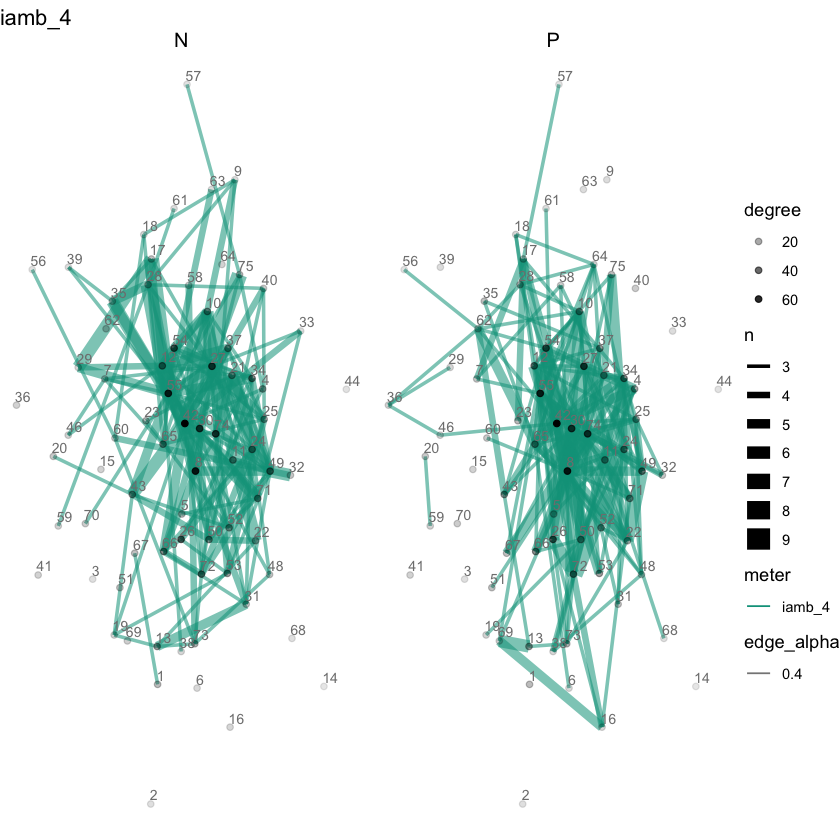

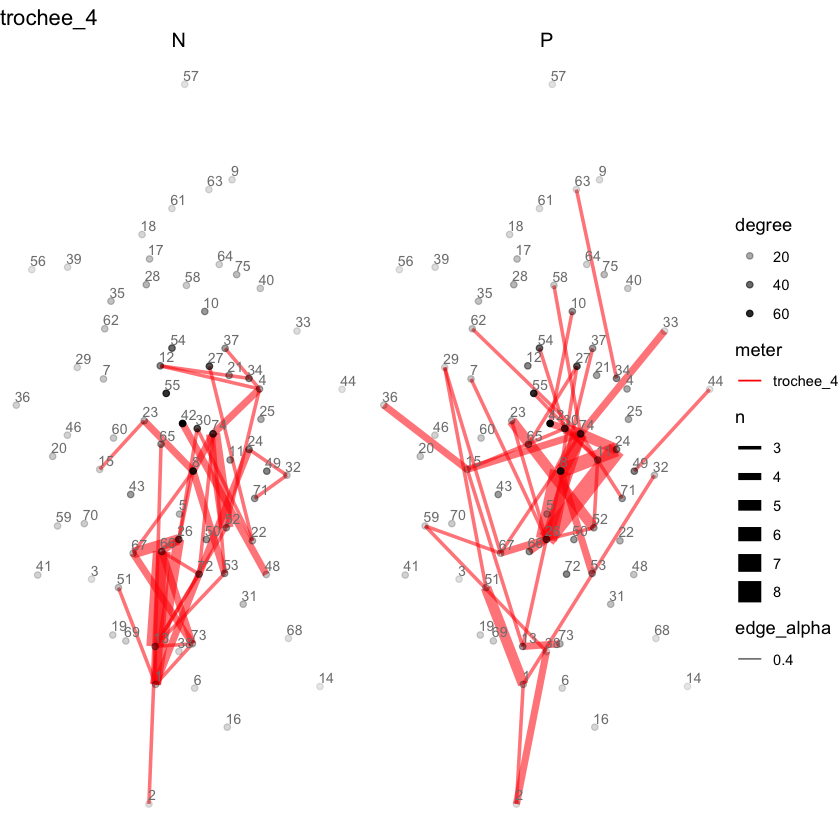

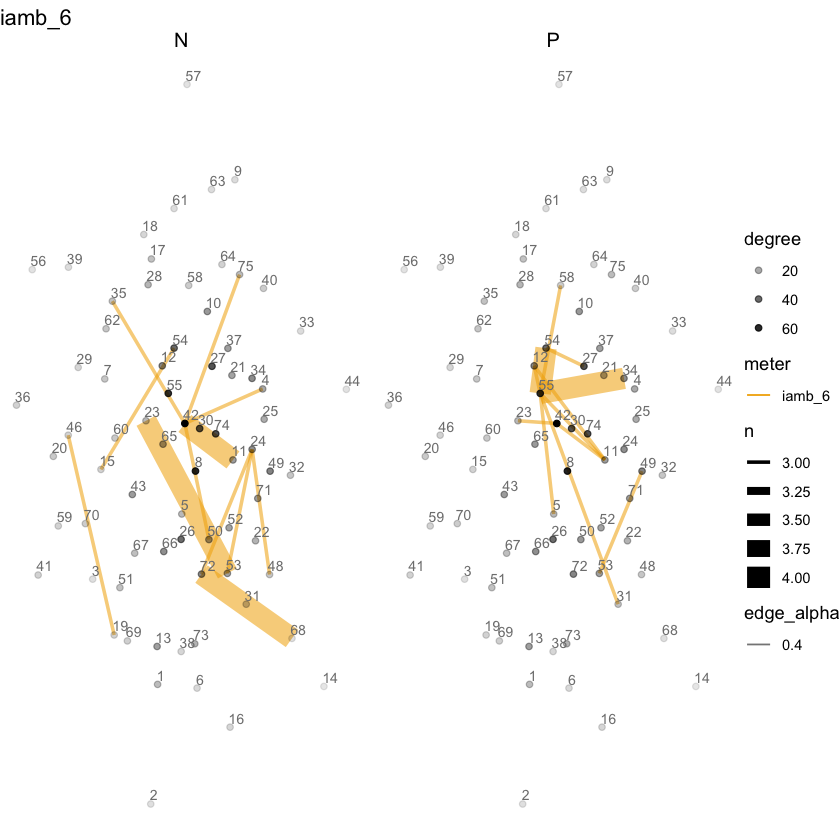

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


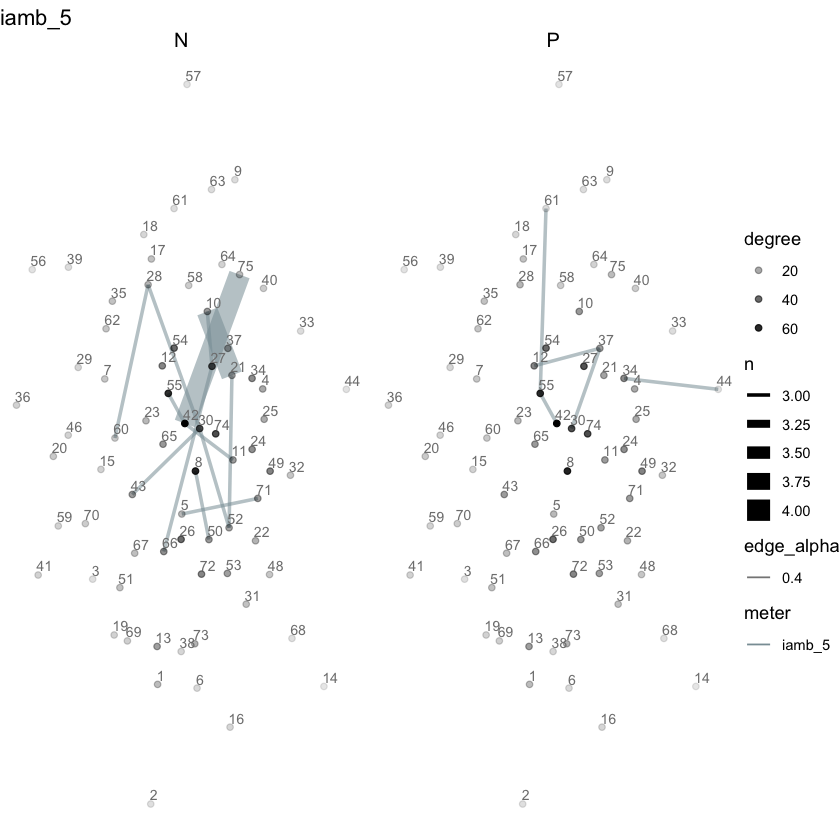

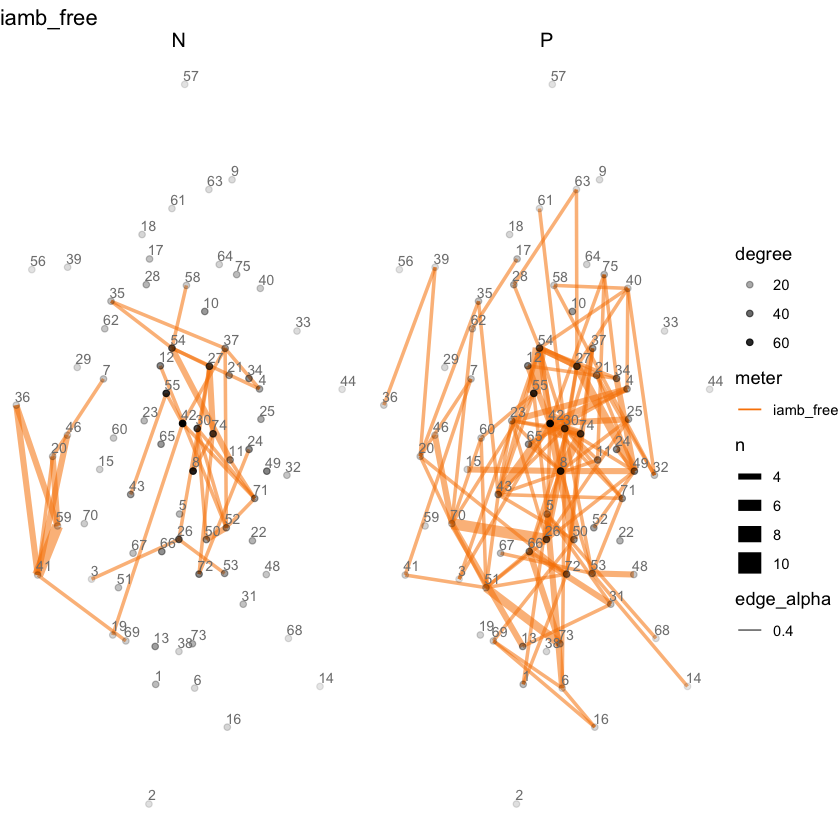

In [59]:
plotlist

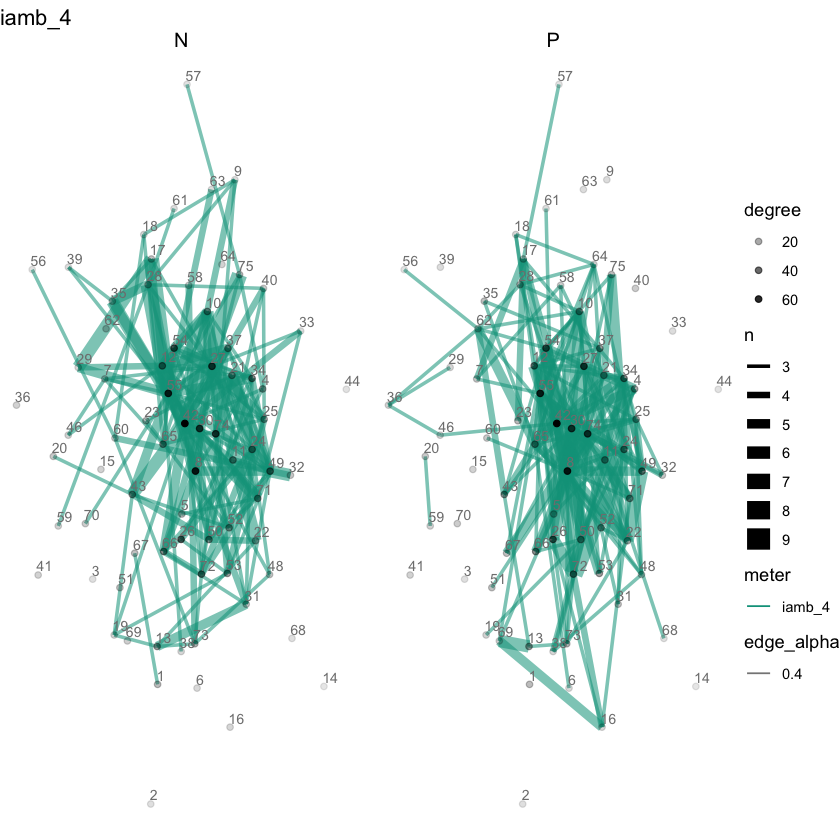

In [56]:
plotlist[[1]]